
# GHZ decoherence under phase noise



## Introduction

This notebook studies **memoryless (Markovian) pure dephasing** on an $N$-qubit **GHZ** state. I quantify coherence drop of **GHZ** state using **fidelity** and **logarithmic negativity**.

### Why GHZ and dephasing?
- GHZ states, $\lvert \mathrm{GHZ}_N\rangle=\big(\lvert 0^{\otimes N}\rangle+\lvert 1^{\otimes N}\rangle\big)/\sqrt{2}$, are maximally sensitive to **phase noise** because their coherence is carried entirely by the off-diagonal element $\lvert 0^N\rangle\!\langle 1^N\rvert$.
- **Markovian dephasing** models fast, memoryless $Z$-type fluctuations. In this regime, **dynamic decoupling** (e.g., $Z$ echoes) does not help, which provides a clean baseline.



### What I do here
- Build circuits that prepare GHZ and accrue dephasing through explicit waits.
- Compute **analytic** $F(d)$ and **simulate** $F(d)$; overlay to validate modeling.
- Plot **logarithmic negativity** vs. depth for $n\in\{3,4,5\}$.
- Provide minimal, reproducible code so parameters $(n,\lambda,r,d)$ can be swept easily.

**Assumptions & scope.** Noise acts **only** during waits (no gate-time on $H/\mathrm{CX}$), is **Markovian** and **independent** across qubits and hits. Time-based $T_2$, amplitude damping, gate noise, and correlated/non-Markovian effects are out of scope here but can be added to test deviations from the analytic baseline.



## Theory

This section summarizes the analytic model for **memoryless (Markovian) pure dephasing** acting on an $N$-qubit **GHZ** state, and the entanglement metric I use (**logarithmic negativity**). It also explains how circuit structure (depth, “wait” layers, repeats) maps to predicted observables.

### GHZ state and observables

The $N$-qubit GHZ state is
$$
\lvert \mathrm{GHZ}_N\rangle
= \frac{\lvert 0^{\otimes N}\rangle + \lvert 1^{\otimes N}\rangle}{\sqrt{2}}.
$$

Two key quantities:
- **Fidelity to GHZ**:
  $$
  F(\rho) \equiv \langle \mathrm{GHZ}_N \rvert \rho \lvert \mathrm{GHZ}_N \rangle .
  $$
- **Logarithmic negativity** across the $1|(N{-}1)$ cut:
  $$
  \mathcal{E}_N(\rho) \equiv \log_2 \big\| \rho^{T_A} \big\|_1 ,
  $$
  where $T_A$ is partial transpose on subsystem $A$ (here the first qubit).

### Phase-damping (dephasing) channel

Single-qubit **phase damping** with Kraus parameter $\lambda\in[0,1]$ has Kraus operators
$$
K_0=\begin{pmatrix}1&0\\[2pt]0&\sqrt{1-\lambda}\end{pmatrix},\qquad
K_1=\begin{pmatrix}0&0\\[2pt]0&\sqrt{\lambda}\end{pmatrix}.
$$
It suppresses off-diagonal terms by the **coherence factor**
$$
c \equiv \sqrt{1-\lambda}.
$$

**Time-based view.** For a wait of duration $\Delta t$ under a Markovian $T_2$ process,
$$
c = e^{-\Delta t/T_2},\qquad
\lambda = 1 - c^2 = 1 - e^{-2\Delta t/T_2}.
$$

### Circuit model (wait-only noise)

I explicitly insert **wait layers** (identity gates). If a circuit has:
- total depth $d$ (one preparation layer + $d{-}1$ wait layers),
- $r$ identity “wait” gates per qubit per wait layer,

then each qubit experiences
$$
\text{hits per qubit} = r\,(d-1)
$$
applications of the phase-damping channel. Assuming **independent**, **Markovian** dephasing and no noise on preparation/entangling gates, the GHZ coherence decays as
$$
\gamma(d) \;=\; c^{\,N \, r \, (d-1)} .
$$

### Analytic fidelity

Because GHZ’s fidelity depends only on the preserved coherence in the $\{\lvert 0^N\rangle,\lvert 1^N\rangle\}$ subspace,
$$
F(d) \;=\; \tfrac12\Big(1+\gamma(d)\Big)
\;=\; \tfrac12\!\left(1 + c^{\,N r (d-1)}\right).
$$

### Logarithmic negativity (cut $1|(N{-}1)$)

For a dephased GHZ that remains in its two-dimensional subspace,
$$
\rho(\gamma) =
\tfrac12\!\left(\lvert 0^N\rangle\langle 0^N\rvert+\lvert 1^N\rangle\langle 1^N\rvert\right)
+ \tfrac{\gamma}{2}\!\left(\lvert 0^N\rangle\langle 1^N\rvert+\lvert 1^N\rangle\langle 0^N\rvert\right),
$$
one finds
$$
\big\|\rho(\gamma)^{T_A}\big\|_1 = 1 + |\gamma|
\;\;\Rightarrow\;\;
\boxed{\,\mathcal{E}_N\big(\rho(\gamma)\big) = \log_2\!\big(1+|\gamma|\big)\, }.
$$
Since $F=\tfrac{1+\gamma}{2}$, for $F\ge \tfrac12$ this reduces to
$$
\boxed{\,\mathcal{E}_N = \log_2(2F)\, }.
$$
Combining with the depth scaling,
$$
\boxed{\,\mathcal{E}_N(d) = \log_2\!\Big(1 + c^{\,N r (d-1)}\Big)\, }.
$$


## Methods

This section describes how I build the circuits, model memoryless dephasing, and compute/compare analytic and simulated observables.

### Circuit construction
- Prepare GHZ on $N$ qubits: apply $H$ on qubit 0, then a linear chain of $\mathrm{CX}(q, q{+}1)$ for $q=0,\dots,N-2$.
- Define **depth** $d\!\ge\!1$: one **preparation** layer plus $d-1$ **wait** layers.
- Each wait layer applies $r$ identity gates per qubit (explicit “waits”), separated by barriers to prevent removal during transpilation.

### Noise model (Markovian dephasing)
- Each identity (wait) is a **phase-damping** hit with Kraus parameter $\lambda\!\in[0,1]$; single-hit coherence factor $c=\sqrt{1-\lambda}$.
- Hits are **independent across qubits** and **memoryless across time** (Markovian).
- Baseline: noise acts **only** on waits (no noise on $H/\mathrm{CX}$).

### Analytic predictions
With $r$ repeats per wait, total waits per qubit are $r(d-1)$, so the GHZ coherence decays as
$$
\gamma(d)=c^{\,N\,r\,(d-1)} .
$$
The **fidelity** to ideal GHZ and **logarithmic negativity** (cut $1|(N{-}1)$) are
$$
F(d)=\tfrac12\!\left(1+\gamma(d)\right), \qquad
\mathcal{E}_N(d)=\log_2\!\big(1+\gamma(d)\big).
$$

## Simulation
Two interchangeable implementations:
- **Qiskit Aer (density-matrix):** attach `phase_damping_error(λ)` to gate `'id'` (and optionally `'cx'`), transpile with `basis_gates=['id']`, `optimization_level=0`, and call `save_density_matrix()`; set simulator/transpiler seeds for reproducibility.
- **NumPy Kraus (reference):** start from $\rho_{\mathrm{GHZ}}$, and for each wait hit apply the single-qubit Kraus map to every qubit; repeat for $r(d-1)$ hits.

## Observables
- **Fidelity:** $F(\rho)=\langle \mathrm{GHZ}_N|\rho|\mathrm{GHZ}_N\rangle$.
- **Logarithmic negativity (cut $1|(N{-}1)$):** form $\rho^{T_A}$ by transposing indices of the first qubit, compute the trace norm via SVD, then
$$
\mathcal{E}_N(\rho)=\log_2\big\|\rho^{T_A}\big\|_1 .
$$

## Procedure
1. Choose $(N,\lambda,r)$ and sweep depths $d=1,\dots,d_{\max}$.
2. Compute $F_{\text{an}}(d)$ and $\mathcal{E}_{N,\text{an}}(d)$ via the formulas above.
3. Simulate $\rho(d)$ and evaluate $F_{\text{sim}}(d)$ (and optionally $\mathcal{E}_{N,\text{sim}}(d)$).
4. Plot overlays $F_{\text{sim}}$ vs. $F_{\text{an}}$ and report residuals $F_{\text{sim}}-F_{\text{an}}$.
5. Repeat for $N\in\{3,4,5\}$.

## Assumptions & checks
- Assumes waits are preserved (barriers, low optimization) and dephasing is **wait-only** and **independent**


In [67]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, DensityMatrix, state_fidelity, partial_trace
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, phase_damping_error

In [68]:
# This function creates the noise model. A single-qubit phase-damping error is attached to identity.

def make_phase_noise_model(p_phase: float) -> NoiseModel:
    """
    Phase-damping noise model.

    Inputs
    p_phase : float in [0,1]
        Phase-damping probability per single-qubit gate application.

    Output
    noise_model : NoiseModel
        1q phase damping on selected 1q gates (including 'id'),
    """
    if not (0 <= p_phase <= 1):
        raise ValueError("p_phase must be in [0,1].")

    oneq = ['id'] 
    

    nm = NoiseModel()
    err_1q = phase_damping_error(p_phase)
    nm.add_all_qubit_quantum_error(err_1q, oneq)

   
    return nm


## GHZ with idle layers

I prepare GHZ, then add (depth − 1) idle layers. Each idle layer applies id to every qubit and then a barrier to stop optimizations that would remove the identities.


In [69]:
# This circuit prepares GHZ once and then appends identity gates per layer. 
# The barrier after each idle layer tells the transpiler not to remove those identities, so the noise model can act at each layer.
def ghz_with_idle_layers(n: int, depth: int) -> QuantumCircuit:
    """
    Prepare GHZ once, then add (depth-1) idle layers that accrue noise.
    Uses id + barrier so the transpiler keeps the idle gates.
    """
    if n < 2: raise ValueError("n must be >= 2")
    if depth < 1: raise ValueError("depth must be >= 1")

    qc = QuantumCircuit(n)
    # GHZ once
    qc.h(0)
    for j in range(n-1):
        qc.cx(j, j+1)

    # Idle layers
    for _ in range(depth-1):
        for q in range(n):
            qc.id(q)           # where 1q noise attaches
        qc.barrier()           # prevents removal/merging of the id's
    return qc


I run depths 1 to max depth, save the final density matrix, and compute fidelity to the ideal GHZ state prepared once (depth 1).


In [70]:
# This function runs the simulation for depths from 1 up to max_depth. 
# It uses the noise model, keeps the identities via optimization_level=0, saves the final density matrix
# Computes fidelity against the ideal GHZ state.

def fidelity_vs_depth(n: int = 4, p_phase: float = 0.02, max_depth: int = 12):
    """
    Compute fidelity to the ideal n-qubit GHZ as depth increases.

    Inputs
    n : int        Number of qubits (>=2). Default 4.
    p_phase : float  Phase-damp prob per gate in [0,1]. Default 0.02.
    max_depth : int  Max layers (>=1). Default 12.

    Outputs
    depths : np.ndarray [1..max_depth]
    fidelities : np.ndarray values in [0,1]
    """
    if n < 2: raise ValueError("n must be >= 2.")
    if not (0 <= p_phase <= 1): raise ValueError("p_phase in [0,1].")
    if max_depth < 1: raise ValueError("max_depth must be >= 1.")

    noise = make_phase_noise_model(p_phase)
    sim = AerSimulator(method="density_matrix", noise_model=noise)

    # Ideal GHZ is depth=1 of this construction
    ghz_ideal_sv = Statevector.from_label('0'*n).evolve(ghz_with_idle_layers(n, 1))
    ghz_ideal = DensityMatrix(ghz_ideal_sv)

    depths = np.arange(1, max_depth+1)
    fidelities = []

    for d in depths:
        qc = ghz_with_idle_layers(n, d)
        qc.save_density_matrix()                  # ensure density matrix is saved
        tqc = transpile(qc, sim, optimization_level=0)
        result = sim.run(tqc, shots=1).result()
        rho = result.data(0)['density_matrix']    # key present because we saved
        fidelities.append(state_fidelity(rho, ghz_ideal))

    return depths, np.asarray(fidelities, dtype=float)



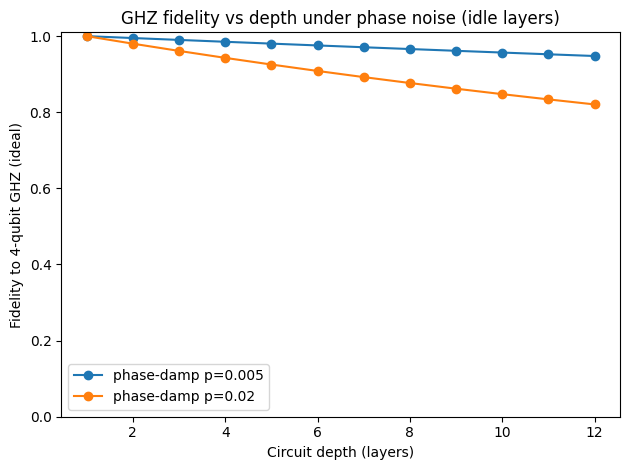

In [71]:
fig, ax = plt.subplots()

for p in [0.005, 0.02]:
    D, F = fidelity_vs_depth(n=4, p_phase=p, max_depth=12)
    ax.plot(D, F, marker='o', label=f"phase-damp p={p}")

ax.set_xlabel("Circuit depth (layers)")
ax.set_ylabel("Fidelity to 4-qubit GHZ (ideal)")
ax.set_ylim(0, 1.01)
ax.set_title("GHZ fidelity vs depth under phase noise (idle layers)")
ax.legend()
fig.tight_layout()

# Save next to the notebook (no folders needed)
fig.savefig("ghz_fidelity.png", dpi=200)
plt.show()




In [72]:
for p in [0.005, 0.02]:
    D, F = fidelity_vs_depth(n=4, p_phase=p, max_depth=12)
    drop = (1 - F[-1]) * 100
    print(f"p={p}: F(start)={F[0]:.4f}, F(end)={F[-1]:.4f}, drop={drop:.2f}%")


p=0.005: F(start)=1.0000, F(end)=0.9478, drop=5.22%
p=0.02: F(start)=1.0000, F(end)=0.8206, drop=17.94%


## Repeats and echo

Repeats controls how many identity operations are in each wait layer, emulating longer per-layer idle time.  
echo inserts Z on even-numbered wait layers.


In [73]:
# I add two new controls. Repeats multiply the number of identity operations per layer, emulating longer idle time per layer. 
# Echo inserts Z on even-numbered wait layers. 
# With our noise attachment, Z does not add extra dephasing hits; it only flips phase, which lets us compare echo versus no-echo fairly.
def build_ghz_with_wait(n: int, depth: int, repeats: int = 1, echo: bool = False) -> QuantumCircuit:
    """
    Build a GHZ circuit once, then add (depth-1) idle 'wait' layers.

    Inputs
    n : int
        Number of qubits (>= 2).
    depth : int
        Total layers. Layer 1 prepares GHZ; layers 2..depth are 'wait' layers.
    repeats : int
        Number of identity operations per qubit per wait layer (>=1).
        Larger repeats -> more noise per layer.
    echo : bool
        If True, apply Z to all qubits on every even-numbered wait layer.

    Outputs
    qc : QuantumCircuit
        Circuit implementing GHZ + wait layers (with optional Z echoes).
    """
    if n < 2: raise ValueError("n must be >= 2")
    if depth < 1: raise ValueError("depth must be >= 1")
    if repeats < 1: raise ValueError("repeats must be >= 1")

    qc = QuantumCircuit(n)
    # GHZ preparation
    qc.h(0)
    for j in range(n-1):
        qc.cx(j, j+1)

    # Wait (idle) layers to accrue dephasing noise
    for layer in range(1, depth):
        if echo and (layer % 2 == 0):
            for q in range(n):
                qc.z(q)
        for _ in range(repeats):
            for q in range(n):
                qc.id(q)
        qc.barrier()  # preserve idle structure through transpilation
    return qc


In [74]:
def ghz_fidelity_sweep(
    n: int = 4,
    p_phase: float = 0.02,
    max_depth: int = 12,
    repeats: int = 1,
    echo: bool = False
):
    """
    Sweep circuit depth and compute fidelity to ideal GHZ using build_ghz_with_wait.

    Inputs
    n : int
        Number of qubits (>=2).
    p_phase : float
        Phase-damping probability per gate in [0,1].
    max_depth : int
        Maximum number of layers (>=1).
    repeats : int
        Identity repetitions per wait layer (>=1).
    echo : bool
        If True, insert Z-echo on alternate wait layers.

    Outputs
    depths : np.ndarray
        Array [1, 2, ..., max_depth].
    fidelities : np.ndarray
        Fidelity values in [0,1] relative to the ideal GHZ state (depth=1).

    """
    if n < 2: raise ValueError("n must be >= 2.")
    if not (0 <= p_phase <= 1): raise ValueError("p_phase in [0,1].")
    if max_depth < 1: raise ValueError("max_depth must be >= 1.")
    if repeats < 1: raise ValueError("repeats must be >= 1.")

    noise = make_phase_noise_model(p_phase)
    sim = AerSimulator(method="density_matrix", noise_model=noise)

    # Ideal reference = depth 1 with the same options
    ideal = DensityMatrix(
        Statevector.from_label('0'*n).evolve(
            build_ghz_with_wait(n, 1, repeats=repeats, echo=echo)
        )
    )

    depths = np.arange(1, max_depth+1, dtype=int)
    fidelities = []
    for d in depths:
        qc = build_ghz_with_wait(n, d, repeats=repeats, echo=echo)
        qc.save_density_matrix()
        tqc = transpile(qc, sim, optimization_level=0)
        result = sim.run(tqc, shots=1).result()
        rho = result.data(0)['density_matrix']
        fidelities.append(state_fidelity(rho, ideal))

    return depths, np.asarray(fidelities, dtype=float)


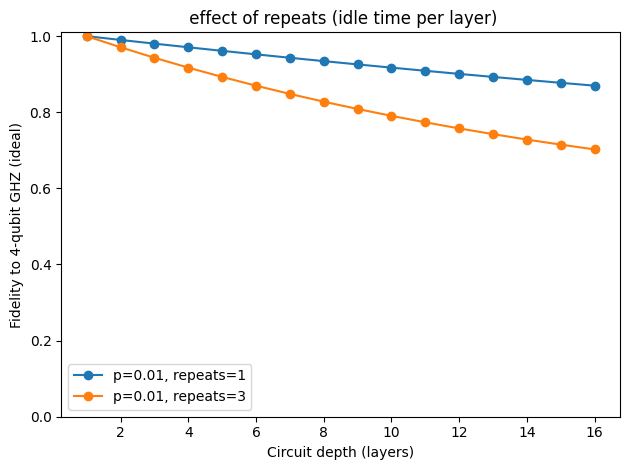

In [75]:
fig, ax = plt.subplots()
for rep in [1, 3]:
    D, F = ghz_fidelity_sweep(n=4, p_phase=0.01, max_depth=16, repeats=rep, echo=False)
    ax.plot(D, F, marker='o', label=f"p=0.01, repeats={rep}")

ax.set_xlabel("Circuit depth (layers)")
ax.set_ylabel("Fidelity to 4-qubit GHZ (ideal)")
ax.set_ylim(0, 1.01)
ax.set_title(" effect of repeats (idle time per layer)")
ax.legend()
fig.tight_layout()
fig.savefig("ghz_fidelity_repeats.png", dpi=200)
plt.show()



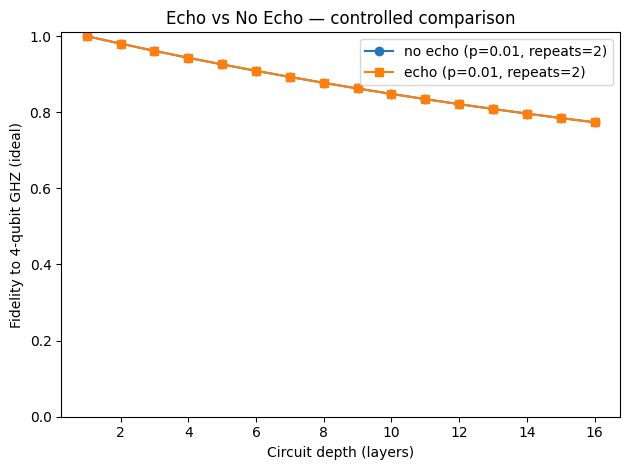

depth  1: ΔF = +0.0000
depth  2: ΔF = +0.0000
depth  3: ΔF = +0.0000
depth  4: ΔF = +0.0000
depth  5: ΔF = +0.0000
depth  6: ΔF = +0.0000
depth  7: ΔF = +0.0000
depth  8: ΔF = +0.0000
depth  9: ΔF = +0.0000
depth 10: ΔF = +0.0000
depth 11: ΔF = +0.0000
depth 12: ΔF = +0.0000
depth 13: ΔF = +0.0000
depth 14: ΔF = +0.0000
depth 15: ΔF = +0.0000
depth 16: ΔF = +0.0000


In [76]:
p = 0.01
reps = 2
max_d = 16

D_no, F_no = ghz_fidelity_sweep(n=4, p_phase=p, max_depth=max_d, repeats=reps, echo=False)
D_ec, F_ec = ghz_fidelity_sweep(n=4, p_phase=p, max_depth=max_d, repeats=reps, echo=True)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(D_no, F_no, marker='o', label=f"no echo (p={p}, repeats={reps})")
ax.plot(D_ec, F_ec, marker='s', label=f"echo (p={p}, repeats={reps})")
ax.set_xlabel("Circuit depth (layers)")
ax.set_ylabel("Fidelity to 4-qubit GHZ (ideal)")
ax.set_ylim(0, 1.01)
ax.set_title("Echo vs No Echo — controlled comparison")
ax.legend()
fig.tight_layout()
fig.savefig("ghz_fidelity_echo.png", dpi=200)
plt.show()

# print the per-depth improvement
improvement = np.array(F_ec) - np.array(F_no)
for d, imp in zip(D_no, improvement):
    print(f"depth {d:2d}: ΔF = {imp:+.4f}")


## Extra runs for p = 0.005 and p = 0.02

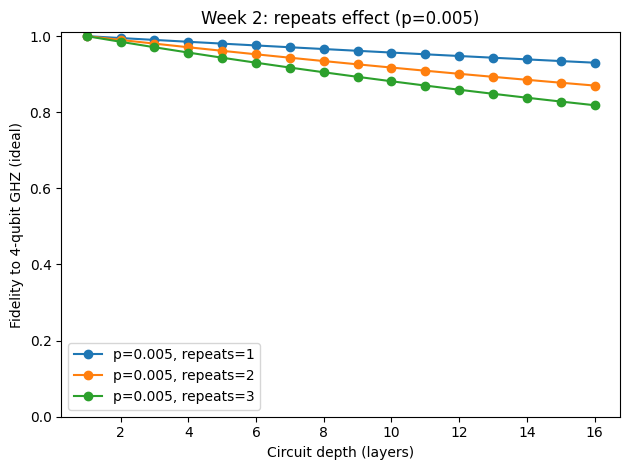

In [77]:
p = 0.005
fig, ax = plt.subplots()
for rep in [1, 2, 3]:
    D, F = ghz_fidelity_sweep(n=4, p_phase=p, max_depth=16, repeats=rep, echo=False)
    ax.plot(D, F, marker='o', label=f"p={p}, repeats={rep}")
ax.set_xlabel("Circuit depth (layers)")
ax.set_ylabel("Fidelity to 4-qubit GHZ (ideal)")
ax.set_ylim(0, 1.01)
ax.set_title("Week 2: repeats effect (p=0.005)")
ax.legend()
fig.tight_layout()
fig.savefig("ghz_fidelity_repeats_p0005.png", dpi=200)
plt.show()


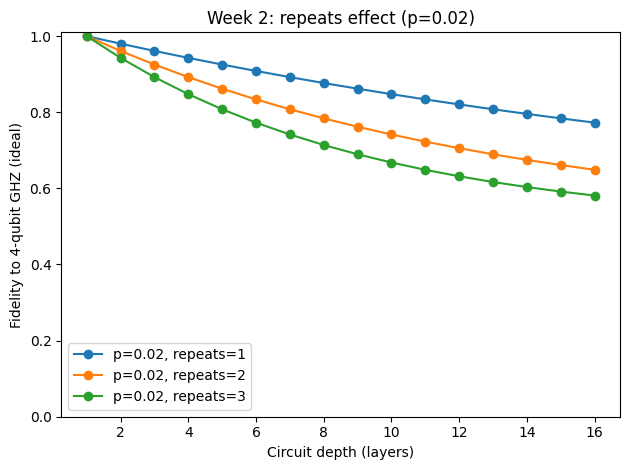

In [78]:
p = 0.02
fig, ax = plt.subplots()
for rep in [1, 2, 3]:
    D, F = ghz_fidelity_sweep(n=4, p_phase=p, max_depth=16, repeats=rep, echo=False)
    ax.plot(D, F, marker='o', label=f"p={p}, repeats={rep}")
ax.set_xlabel("Circuit depth (layers)")
ax.set_ylabel("Fidelity to 4-qubit GHZ (ideal)")
ax.set_ylim(0, 1.01)
ax.set_title("Week 2: repeats effect (p=0.02)")
ax.legend()
fig.tight_layout()
fig.savefig("ghz_fidelity_repeats_p0020.png", dpi=200)
plt.show()


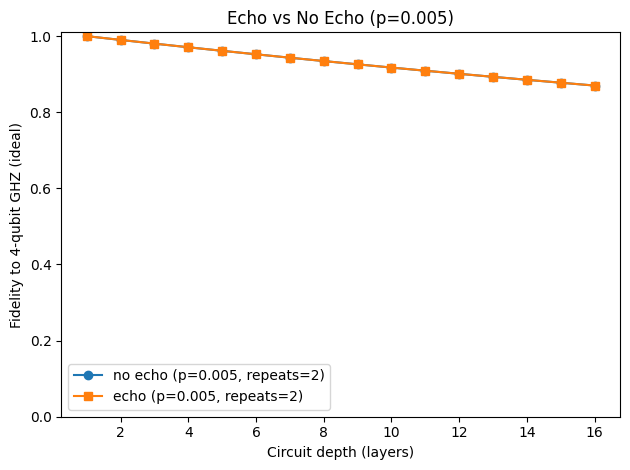

ΔF per depth (echo - no echo):
depth  1: ΔF = +0.0000
depth  2: ΔF = +0.0000
depth  3: ΔF = +0.0000
depth  4: ΔF = +0.0000
depth  5: ΔF = +0.0000
depth  6: ΔF = +0.0000
depth  7: ΔF = +0.0000
depth  8: ΔF = +0.0000
depth  9: ΔF = +0.0000
depth 10: ΔF = +0.0000
depth 11: ΔF = +0.0000
depth 12: ΔF = +0.0000
depth 13: ΔF = +0.0000
depth 14: ΔF = +0.0000
depth 15: ΔF = +0.0000
depth 16: ΔF = +0.0000


In [79]:
p = 0.005
reps = 2
max_d = 16

D_no, F_no = ghz_fidelity_sweep(n=4, p_phase=p, max_depth=max_d, repeats=reps, echo=False)
D_ec, F_ec = ghz_fidelity_sweep(n=4, p_phase=p, max_depth=max_d, repeats=reps, echo=True)

fig, ax = plt.subplots()
ax.plot(D_no, F_no, marker='o', label=f"no echo (p={p}, repeats={reps})")
ax.plot(D_ec, F_ec, marker='s', label=f"echo (p={p}, repeats={reps})")
ax.set_xlabel("Circuit depth (layers)")
ax.set_ylabel("Fidelity to 4-qubit GHZ (ideal)")
ax.set_ylim(0, 1.01)
ax.set_title("Echo vs No Echo (p=0.005)")
ax.legend()
fig.tight_layout()
fig.savefig("ghz_fidelity_echo_p0005.png", dpi=200)
plt.show()

print("ΔF per depth (echo - no echo):")
for d, df in zip(D_no, (np.array(F_ec) - np.array(F_no))):
    print(f"depth {d:2d}: ΔF = {df:+.4f}")


# GHZ size comparison (n = 3, 4, 5)

I compare fidelity vs depth for different GHZ sizes under the same phase noise.  
Expectation: larger GHZ (more qubits) loses global coherence faster.



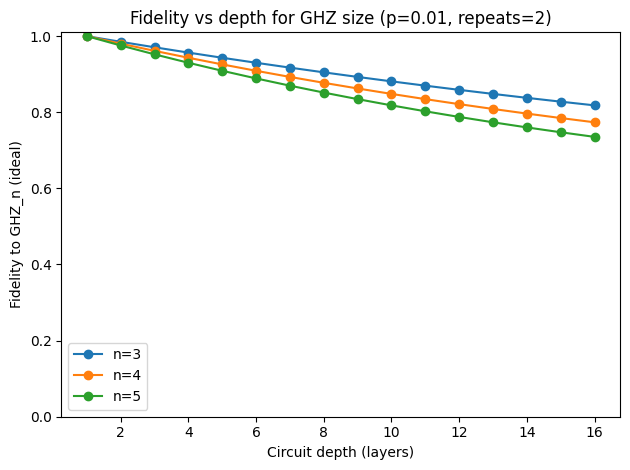

In [80]:
# GHZ size comparison
p = 0.01
max_depth = 16
sizes = [3, 4, 5]
repeats = 2

fig, ax = plt.subplots()
for n in sizes:
    D, F = ghz_fidelity_sweep(n=n, p_phase=p, max_depth=max_depth, repeats=2, echo=False)
    ax.plot(D, F, marker='o', label=f"n={n}")
ax.set_xlabel("Circuit depth (layers)")
ax.set_ylabel("Fidelity to GHZ_n (ideal)")
ax.set_ylim(0, 1.01)
ax.set_title(f"Fidelity vs depth for GHZ size (p={p}, repeats=2)")
ax.legend()
fig.tight_layout()
fig.savefig("ghz_size_comparison.png", dpi=200)
plt.show()


In [81]:
# Run sweeps once
series = {}
for n in sizes:
    D, F = ghz_fidelity_sweep(n=n, p_phase=p, max_depth=max_depth, repeats=repeats, echo=False)
    series[n] = F

# Print header
print("depth," + ",".join([f"F_n{n}" for n in sizes]))

# Print rows
for i, d in enumerate(range(1, max_depth + 1)):
    row = [str(d)] + [f"{series[n][i]:.8f}" for n in sizes]
    print(",".join(row))


depth,F_n3,F_n4,F_n5
1,1.00000000,1.00000000,1.00000000
2,0.98514950,0.98029801,0.97549503
3,0.97074008,0.96137235,0.95219104
4,0.95675863,0.94319244,0.93002918
5,0.94319244,0.92572889,0.90895347
6,0.93002918,0.90895347,0.88891068
7,0.91725689,0.89283908,0.86985019
8,0.90486394,0.87735965,0.85172385
9,0.89283908,0.86249017,0.83448589
10,0.88117136,0.84820661,0.81809275
11,0.86985019,0.83448589,0.80250304
12,0.85886527,0.82130581,0.78767738
13,0.84820661,0.80864508,0.77357833
14,0.83786453,0.79648323,0.76017027
15,0.82782962,0.78480061,0.74741934
16,0.81809275,0.77357833,0.73529333


## A diagram for the circuit and setup

In [82]:
# Logical circuit 
n, depth, repeats = 4, 6, 2

qc_no = build_ghz_with_wait(n=n, depth=depth, repeats=repeats, echo=False)
qc_ec = build_ghz_with_wait(n=n, depth=depth, repeats=repeats, echo=True)

print("Logical circuit — no echo")
print(qc_no.draw(output="text"))

print("\nLogical circuit — with echo (Z on even wait layers)")
print(qc_ec.draw(output="text"))


Logical circuit — no echo
     ┌───┐     ┌───┐┌───┐           ░ ┌───┐┌───┐ ░ ┌───┐┌───┐ ░ ┌───┐┌───┐ ░ »
q_0: ┤ H ├──■──┤ I ├┤ I ├───────────░─┤ I ├┤ I ├─░─┤ I ├┤ I ├─░─┤ I ├┤ I ├─░─»
     └───┘┌─┴─┐└───┘├───┤┌───┐      ░ ├───┤├───┤ ░ ├───┤├───┤ ░ ├───┤├───┤ ░ »
q_1: ─────┤ X ├──■──┤ I ├┤ I ├──────░─┤ I ├┤ I ├─░─┤ I ├┤ I ├─░─┤ I ├┤ I ├─░─»
          └───┘┌─┴─┐└───┘├───┤┌───┐ ░ ├───┤├───┤ ░ ├───┤├───┤ ░ ├───┤├───┤ ░ »
q_2: ──────────┤ X ├──■──┤ I ├┤ I ├─░─┤ I ├┤ I ├─░─┤ I ├┤ I ├─░─┤ I ├┤ I ├─░─»
               └───┘┌─┴─┐├───┤├───┤ ░ ├───┤├───┤ ░ ├───┤├───┤ ░ ├───┤├───┤ ░ »
q_3: ───────────────┤ X ├┤ I ├┤ I ├─░─┤ I ├┤ I ├─░─┤ I ├┤ I ├─░─┤ I ├┤ I ├─░─»
                    └───┘└───┘└───┘ ░ └───┘└───┘ ░ └───┘└───┘ ░ └───┘└───┘ ░ »
«     ┌───┐┌───┐ ░ 
«q_0: ┤ I ├┤ I ├─░─
«     ├───┤├───┤ ░ 
«q_1: ┤ I ├┤ I ├─░─
«     ├───┤├───┤ ░ 
«q_2: ┤ I ├┤ I ├─░─
«     ├───┤├───┤ ░ 
«q_3: ┤ I ├┤ I ├─░─
«     └───┘└───┘ ░ 

Logical circuit — with echo (Z on even wait layers)
     ┌───┐     ┌───┐┌───┐     

## Logarithmic Negativity 

In [100]:
def build_rho_ghz_dephased(n, gamma):
    """
    Construct an n-qubit GHZ density matrix whose GHZ-subspace coherence is scaled by `gamma`.

    State:
        rho = 1/2(|0...0><0...0| + |1...1><1...1|)
              + 1/2 * gamma (|0...0><1...1| + |1...1><0...0|)

    Inputs
    ------
    n : int
        Number of qubits.
    gamma : float
        Coherence factor in [0, 1] multiplying the GHZ off-diagonal terms.

    Outputs
    -------
    np.ndarray
        Density matrix of shape (2**n, 2**n), dtype complex.
    """
    dim = 2**n
    rho = np.zeros((dim, dim), dtype=complex)
    rho[0, 0] = 0.5
    rho[-1, -1] = 0.5
    rho[0, -1] = 0.5 * gamma
    rho[-1, 0] = 0.5 * gamma
    return rho


def _partial_transpose_A0(rho, n):
    """
    Take the partial transpose of `rho` with respect to qubit 0 (the 1 | (N-1) split).

    Inputs
    ------
    rho : np.ndarray
        Density matrix of shape (2**n, 2**n).
    n : int
        Number of qubits.

    Outputs
    -------
    np.ndarray
        The partially transposed matrix rho^{T_A} with the same shape as `rho`.
    """
    dims = [2] * n
    reshaped = rho.reshape(*(dims + dims))  # ket [0..n-1], bra [n..2n-1]
    reshaped = np.swapaxes(reshaped, 0, n + 0)
    return reshaped.reshape(rho.shape)


def log_negativity_A0(rho, n):
    """
    Compute log-negativity across the 1 | (N-1) bipartition (A = {0}).

    Definition:
        E_N = log2( || rho^{T_A} ||_1 ), with the trace norm computed via SVD.

    Inputs
    ------
    rho : np.ndarray
        Density matrix of shape (2**n, 2**n).
    n : int
        Number of qubits.

    Outputs
    -------
    float
        Log-negativity (in bits).
    """
    rho_PT = _partial_transpose_A0(rho, n)
    svals = np.linalg.svd(rho_PT, compute_uv=False)
    return float(np.log2(svals.sum()))


def compute_log_negativity_curve(n, depths, repeats, p_phase):
    """
    Compute log-negativity vs depth for GHZ under wait-only Markovian dephasing (A={0}).

    Uses c = sqrt(1 - p_phase) and gamma(d) = c^(n * repeats * (d-1)).
    For each depth d, builds a GHZ-subspace density matrix with coherence gamma(d)
    and evaluates the log-negativity.

    Inputs
    ------
    n : int
        Number of qubits.
    depths : int or 1D array-like of int
        Circuit depths (>= 1). Depth=1 means no wait layers.
    repeats : int
        Identity gates per qubit per wait layer.
    p_phase : float
        Phase-damping Kraus parameter per wait gate (0 <= p_phase <= 1).

    Outputs
    -------
    np.ndarray
        Log-negativity values for each depth, same shape as `depths`.
    """
    d = np.asarray(depths, dtype=int)
    c = np.sqrt(1.0 - p_phase)
    gammas = np.power(c, n * repeats * (d - 1))
    EN = np.empty_like(gammas, dtype=float)
    for i, g in enumerate(gammas):
        rho = build_rho_ghz_dephased(n, float(g))
        EN[i] = log_negativity_A0(rho, n)
    return EN



def plot_logneg_multi(depths, n_values, repeats, p_phase):
    """
    Plot log-negativity (A={0}) for several `n` values on one figure.

    Inputs
    ------
    depths : int or 1D array-like of int
        Circuit depths (>= 1).
    n_values : list of int
        Qubit counts to plot, e.g., [3, 4, 5].
    repeats : int
        Identity gates per qubit per wait layer.
    p_phase : float
        Phase-damping Kraus parameter per wait gate.

    Outputs
    -------
    None
        Displays the matplotlib figure.
    """
    d = np.asarray(depths, dtype=int)
    for n in n_values:
        EN = compute_log_negativity_curve(n, d, repeats, p_phase)
        plt.plot(d, EN, 'o-', label=f'n={n}')
    plt.xlabel('Circuit depth $d$')
    plt.ylabel('Log-negativity $\\mathcal{E}_N(1\\,|\\,N-1)$')
    plt.title('Log-negativity vs Depth')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [112]:
def plot_log_negativity_vs_depth(depths, EN, n=None, p_phase=None, title=None):
    """
    Plot log-negativity vs circuit depth for the $1\,|\,(N-1)$ bipartition.

    Inputs
    depths : int or 1D array-like of int
        Circuit depths (>= 1). Depth = 1 means no wait layers.
    EN : array-like of float
        Log-negativity values corresponding to `depths`.
    n : int, optional
        Number of qubits (used only to annotate the title).
    p_phase : float, optional
        Per-wait phase-damping probability (used only to annotate the title).
    title : str, optional
        Custom figure title. If omitted, a title is generated as:
        "Log-negativity vs Depth (n=..., $p_{\\text{phase}}$=...)".

    Outputs
        Displays a Matplotlib figure of $\\mathcal{E}_N(1\,|\,N-1)$ versus depth.

    """
    plt.figure()
    plt.plot(depths, EN, 'o-')
    plt.xlabel('Circuit depth $d$')
    plt.ylabel('Log-negativity $\\mathcal{E}_N\\;(1\\,|\\,N-1)$')
    if title is None:
        extras = []
        if n is not None:
            extras.append(f"n={n}")
        if p_phase is not None:
            extras.append(f"$p_\\text{{phase}}$={p_phase}")
        title = "Log-negativity vs Depth" + (f" ({', '.join(extras)})" if extras else "")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


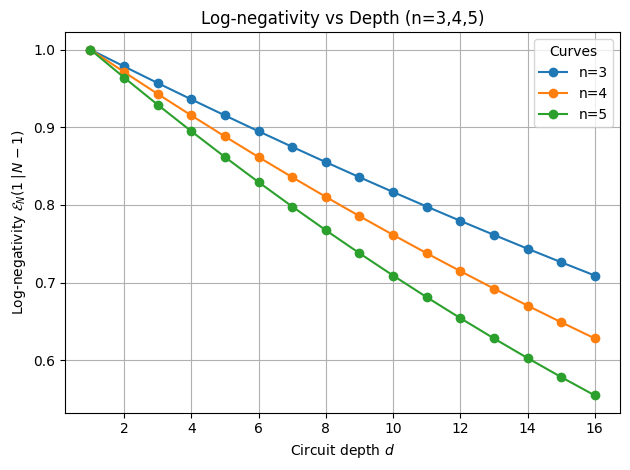

depth,EN_n3,EN_n4,EN_n5
1,1.00000000,1.00000000,1.00000000
2,0.97830584,0.97114805,0.96402705
3,0.95694282,0.94288466,0.92897346
4,0.93591070,0.91520910,0.89483750
5,0.91520910,0.88812018,0.86161623
6,0.89483750,0.86161623,0.82930559
7,0.87479521,0.83569510,0.79790041
8,0.85508140,0.81035421,0.76739439
9,0.83569510,0.78559049,0.73778017
10,0.81663519,0.76140046,0.70904938
11,0.79790041,0.73778017,0.68119262
12,0.77948935,0.71472530,0.65419958
13,0.76140046,0.69223108,0.62805902
14,0.74363206,0.67029237,0.60275887
15,0.72618235,0.64890364,0.57828627
16,0.70904938,0.62805902,0.55462761


In [113]:
# Parameters
n_values = [3, 4, 5]
p_phase = 0.02
max_depth = 16
repeats = 1
depths = np.arange(1, max_depth + 1, dtype=int)

# Compute once per n
EN_series = {n: compute_log_negativity_curve(n, depths, repeats, p_phase) for n in n_values}

# Plot
plt.figure()
for n in n_values:
    EN_vals = EN_series[n]
    plt.plot(depths, EN_vals, 'o-', label=f'n={n}')
plt.xlabel('Circuit depth $d$')
plt.ylabel('Log-negativity $\\mathcal{E}_N(1\\,|\\,N-1)$')
plt.title('Log-negativity vs Depth (n=3,4,5)')
plt.legend(title='Curves')
plt.grid(True)
plt.tight_layout()
fig.savefig("ghz_log_negativity.png", dpi=200)
plt.show()

# Numbers
header = "depth," + ",".join([f"EN_n{n}" for n in n_values])
print(header)
for i, d in enumerate(depths):
    row = [str(d)] + [f"{EN_series[n][i]:.8f}" for n in n_values]
    print(",".join(row))